In [2]:
##### Notebook to show how to use the parser
from use_gsm import *

#paqueterías
import numpy as np
from scipy import interpolate
import sys, platform, os
from scipy import optimize
from scipy.special import gamma, factorial
import zeus
from subprocess import Popen, PIPE
import math
from multiprocessing import Pool
from zeus import ChainManager
import time
from math import e
import h5py



rmin=2.5
rstep=5
dd=30
uu=130
sub1 = int((dd-rmin)/rstep)+1
sub2 = int((uu-rmin)/rstep)+1
nr_sub = sub2-sub1

#2PCF_UNIT_DESI_Shadab_HOD_snap97_ELG_v1_xil.dat
mock_avg_file='./data/2PCF_UNIT_DESI_Shadab_HOD_snap97_ELG_v1_xil.dat' 
ffile='./data/cov_matrix_xi-EZmocks-3Gpc-nonfix_rsd_centerbin.txt'     #Cov_matrix
x, weight = np.loadtxt("./data/gauss.txt", unpack=True)

i,j,cov = np.loadtxt( ffile,unpack=True)
inrange=np.where((i>dd)&(j>dd)&(i<uu)&(j<uu))
cov_cut=cov[inrange]

cov_matrix=np.reshape(cov_cut, (3*(nr_sub),3*(nr_sub)))
covinv = np.linalg.inv(cov_matrix)

#cov_matrix_nohexa= cov_matrix[0:-1*(nr_sub), 0:-1*(nr_sub)]


covinv = np.linalg.inv(cov_matrix) #obtiene la inversa de la covarianza

#Read data
r0,xiin0, xiin2, xiin4 = np.loadtxt(mock_avg_file,usecols=(0,1,2,3), unpack=True)

data = np.zeros(3*nr_sub)
for i in range(0,nr_sub):
    data[i] = xiin0[sub1+i]
    data[i+nr_sub] = xiin2[sub1+i]
    data[i+2*nr_sub] = xiin4[sub1+i]
    


z=0.9873
def replace_line(file_name, line_num, text):
    with open(file_name, 'r') as file:
        # read a list of lines into data
        data = file.readlines()
    
    # now change the 2nd line, note that you have to add a newline
    data[line_num] = text

    # and write everything back
    with open(file_name, 'w') as file:
        file.writelines( data )
        
#interpolación_spllin
def spllin(x_sp, y, x):
    spform = interpolate.splrep(x,y,s=0)
    y_out = interpolate.splev(x_sp,spform,der=0)

    return y_out

    
    
def loglike(params):
    #We define the parameter we are varying
    Om=params[0]
    h=params[1]
    log_As=(params[2])       #math.log(10**10* As )=params[2]
    As=(10**(log_As))/(10**(10))
    sigma2eft=params[3]
    b1=(params[4])
    b2=params[5]
    Omh2 = Om*h**2
    omnuh2=  0.00064*(h**2)/((0.6774)**2) 
    ombh2 = 0.02230 *(h**2)/((0.6774)**2 )
    redshift       = 0.9873
    proc           = 10000
    

    omch2=Omh2-ombh2-omnuh2
    H0=h*100    
    
    
    
    if 0.142e-9<As<4.142e-9 and 0.2<Om<0.35 and  0.65<h<0.72 and -4<b1<4   and -4<b2<4 :
        
        
        current_time = time.time()
        
        
        ##We modify the ini file that give us the linear power spectrum
        replace_line('params_Planck15Table4LastColumn_copy.ini', 35, "ombh2          = "+str(ombh2)+"\n")
        replace_line('params_Planck15Table4LastColumn_copy.ini', 37, "omnuh2         = "+str(omnuh2)+"\n")
        replace_line('params_Planck15Table4LastColumn_copy.ini', 36, "omch2          = "+str(omch2)+"\n")
        replace_line('params_Planck15Table4LastColumn_copy.ini', 39, "hubble         = "+str(H0)+"\n")
        replace_line('params_Planck15Table4LastColumn_copy.ini', 86, "scalar_amp(1)  = "+str(As)+"\n")
        
        pars=camb.read_ini(os.path.join('params_Planck15Table4LastColumn_copy.ini'))
        pars.set_matter_power(redshifts=[redshift])
        
        results = camb.get_results(pars)
        
        #we get the linear power spectrum
        kh, z, pk = results.get_matter_power_spectrum(minkh=0.0001, maxkh=25, npoints = 1000)
        np.savetxt(path_gsm+'Input/ps_%d.txt'%proc, np.array( (kh, pk[0])).T)
    
        
#        generate_ps(proc ,H0=H0, ombh2=ombh2, As=As,  omch2=omch2,  omnuh2=omnuh2   ,  z=[redshift], khmin=0.0001, khmax=25., nbk=1000)
    
        
        
        
        #we get the multipoles of the correlation function
        res_rsd = run_gsm(proc ,pk_name='ps_%d.txt'%proc , Om=Om, h=h,zout=redshift,sigma2eft=sigma2eft, b1=b1, b2=b2 , smin=2.5, smax=197.5 , Ns=40, remove=True )
        
        r_fid_=  res_rsd['s']
        xi0_fid_=res_rsd['mono']
        xi2_fid_=res_rsd['quad']
        xi4_fid_=res_rsd['hexa']


        #we re-scale the given multipoles if desired                                                                 
        rmin_=2.5
        rstep_=5
        dd_=30
        uu_=130
        sub1_ = int((dd_-rmin_)/rstep_)+1
        sub2_ = int((uu_-rmin_)/rstep_)+1
        nr_sub_ = sub2_-sub1_
        
        r_fid_,xi0_fid_,xi2_fid_,xi4_fid_ = r_fid_[sub1_:sub2_],xi0_fid_[sub1_:sub2_],xi2_fid_[sub1_:sub2_],xi4_fid_[sub1_:sub2_]


        #we put the multipoles in a single vector
        model = np.zeros(3*nr_sub)


        for i in range(0,nr_sub): 
            model[i]          = xi0_fid_[i]#[i]
            model[i+nr_sub]   = xi2_fid_[i]#[i]
            model[i+2*nr_sub] = xi4_fid_[i]
            
        #we get the chi2 function
     
        residual = data - model
    
        chi_2 = np.dot(np.dot(residual, covinv), residual)

        print(chi_2)
        
        

        loglike=-0.5*chi_2
        
        #we impose priors on the parameters

        lp0 = 0.
        lp1 = 0.
        lp2 = 0.
        lp3 = 0.
        lp4 = 0
        lp5 = 0
        
        
        ommin = 0.1 # lower range of prior                                                                                                                                                 
        ommax = 0.4  # upper range of prior                                                                                                                                                
        lp0 = 0. if ommin < Om < ommax else -np.inf

                                                                                                                                 

        hmin = 0.65 # lower range of prior                                                                                                                                               
        hmax = 0.71  # upper range of prior                                                                                                                                               
        lp1 = 0. if hmin < h < hmax else -np.inf
        
        
        
        log_Asmin = np.log10(10**10*0.151013363383038e-09) # lower range of prior                                                                                                                                               
        log_Asmax = np.log10(10**10*4.151013363383038e-09)  # upper range of prior                                                                                                                                               
        lp5 = 0. if log_Asmin < log_As < log_Asmax else -np.inf

        b1min = -4. # lower range of prior                                                                                                                                         
        b1max = 4.  # upper range of prior                                                                                                                                       
        lp2 = 0. if b1min < b1 < b1max else -np.inf
    
        b2min = -4. # lower range of prior                                                                                                                                         
        b2max = 4.  # upper range of prior                                                                                                                                       
        lp3 = 0. if b2min < b2 < b2max else -np.inf
        
        
        sigma2eftmin = -30. # lower range of prior                                                                                                                                         
        sigma2eftmax = 30.  # upper range of prior                                                                                                                                       
        lp4 = 0. if b2min < b2 < b2max else -np.inf
        
        loglike_tot=loglike+lp0+lp1+lp2+lp3+lp4+lp5

    else:
        loglike_tot=-np.inf
        print(-np.inf)
        
    return loglike_tot
 



Using CAMB 1.1.0 installed at /home/sadi/anaconda3/lib/python3.8/site-packages/camb


In [ ]:
#we get the chain using ZEUZ as a sampler

import zeus
import numpy as np

ndim = 6 # Number of parameters/dimensions (e.g. m and c)                                                                                                                            
nwalkers = 12# Number of walkers to use. It should be at least twice the number of dimensions.                                                                                       
nsteps = 300 # Number of steps/iterations. #3:30 min for each iteration  
nchains = 1


start =start =[(0.308597561544344206, 0.6774 ,  np.log10(10**10* 0.951013363383038e-09 ),10,     0.402,   -0.879945162566224 ),
        (0.302597561544344206,         0.6774,  np.log10(10**10* 0.651013363383038e-09),11.1,    0.432,  -0.83671335),
        (0.306597561544344206,         0.6774,  np.log10(10**10* 0.751013363383038e-09),12.1,    0.42,   -0.80786387),
        (0.308597561544344206,         0.6774,  np.log10(10**10* 0.851013363383038e-09) ,9.1,    0.4,    -0.80783456387),
        (0.308597561544344206,         0.6774,  np.log10(10**10* 2.151013363383038e-09 ),8.1,     0.4,   -0.80786387),
        (0.309597561544344206,         0.6874,  np.log10(10**10* 2.551013363383038e-09 ),10.1,    0.4,  - 0.80786387),
        (0.300597561544344206,          0.6974, np.log10(10**10* 2.651013363383038e-09 ),10.12,    0.41 ,  -0.922),
        (0.300597561544344206,          0.6974, np.log10(10**10* 1.951013363383038e-09 ),10.13,    0.42 ,  -0.823),
        (0.300597561544344206,          0.6874, np.log10(10**10* 2.151013363383038e-09 ),10.14,    0.43 ,  -0.822),
        (0.300597561544344206,          0.6974, np.log10(10**10* 2.153013363383038e-09 ),10.15,    0.44 ,  -0.825),
        (0.300597561544344206,          0.6974, np.log10(10**10* 2.251013363383038e-09 ),10.16,    0.45 ,  -0.826),
        (0.300597561544344206,          0.6974, np.log10(10**10* 2.151013363383038e-09 ),10.17,    0.46 ,  -0.827),
        ]

sampler = zeus.EnsembleSampler(nwalkers, ndim, loglike)
sampler.run_mcmc(start, nsteps, callbacks=zeus.callbacks.SaveProgressCallback("saved2_chains.h5", ncheck=1000))

    
        
   
    
chain = sampler.get_chai45n(flat=True, discard=nsteps//5) 
np.save('./data/chain_nonfixed_30_no_ap', chain)
sampler.summary # Print summary diagnostics



/home/sadi/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1181: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/home/sadi/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1181: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/home/sadi/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1181: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/home/sadi/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1181: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/home/sadi/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1181: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/home/sadi/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1181: UserWarning: The following kwargs were not us

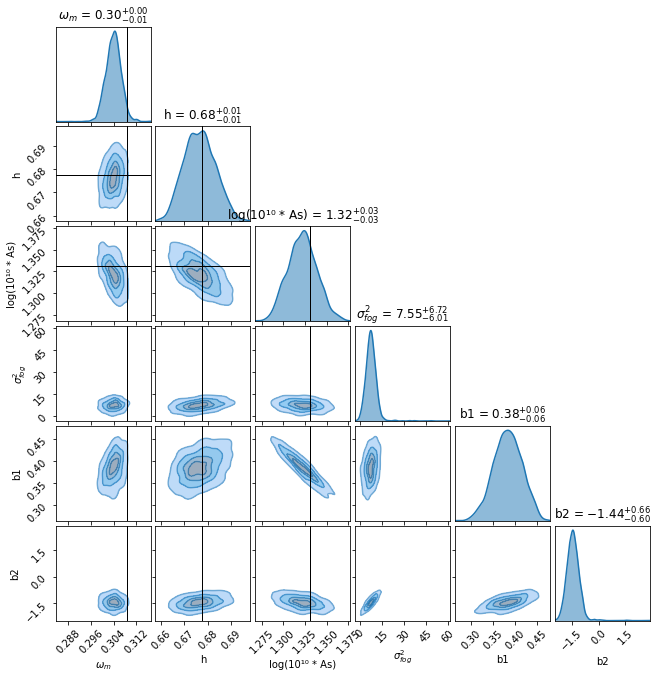

In [5]:
#we get a triangular plot from the chain

om_true=0.308597561544344206
h_true=0.6774
logtrue=np.log10(10**10* 2.142e-9)
sigmatrue=80

b1_true=0
b2_true=8

chain=np.load('./data/chain_nonfixed_30_no_ap.npy')
fig, axes = zeus.cornerplot(chain, labels=['$\omega_{m}$', 'h','log(10¹⁰ * As)','$\sigma^2_{fog}$', 'b1', 'b2'], truth=[om_true, h_true,logtrue, sigmatrue, b1_true,b2_true]);

# Alternative way of plotting

In [4]:
###### Code to generate triangle contour plots using the ZEUS chains
###### This code will allow to compare various chains and use only one chain automatically


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import kde
from scipy import interpolate
%matplotlib inline

import os, sys
from os import listdir
from os.path import isfile, join
import pickle

In [5]:
###### PART TO DEFINE SOME FUNCTIONS


def Initialize_list_stats(list_chain_names, par_names):

    dict_base = {'chain_name':'', 'params':par_names, 'mean':[],
                'median':[], 'sigma':[], 'sigma+':[], 'sigma-':[]}
    
    list_dict = []
    
    for nn in range(len(list_chain_names)):
        mydict = dict_base.copy()
        mydict['chain_name']=list_chain_names[nn]
        list_dict.append(mydict)
    
    return list_dict

###### Gaussian 1,2,3 sigmas: 0.6827, 0.9545, 0.9973

def Get_stats(chain, mydict, percentile=0.6827):
    
    
    for nn in range(len(mydict['params'])):
    
        data = chain[nn]
        nb_x = len(data)

        ind_inf = int(np.floor(nb_x * (0.5 - percentile/2) ) )
        ind_sup = int(np.ceil(nb_x * (0.5 + percentile/2) ) )

        ind_med = int(np.round(nb_x * 0.5 ) )

        data_sorted = np.sort(data)

        mydict['median'].append(data_sorted[ind_med])
        mydict['sigma-'].append(data_sorted[ind_inf] - data_sorted[ind_med])
        mydict['sigma+'].append(data_sorted[ind_sup] - data_sorted[ind_med])
        mydict['mean'].append(np.mean(data))
        mydict['sigma'].append(np.std(data))
    
 



def Read_chains(list_chain_names, burn_in = 0.):

    list_chain = []

    for nn in range(len(list_chain_names)):

        chain1 = np.load(list_chain_names[nn], mmap_mode='r')



        Is_multi_1 = False

        if chain1.ndim == 3: Is_multi_1 = True

        if Is_multi_1 == True:
            nb_1 = len(chain1[0][0])
        else: nb_1 = len(chain1[0])


        ###### Create the void lists

        chain_tot1 = [[] for x in range(nb_1)]

        if Is_multi_1 == True:
            nb = len(chain1)

            chain_tmp = chain1[0]
            #### define the starting index to take into accoount the burn-in
            ind_bi = np.int(np.round(len(chain_tmp) * burn_in ))

            for ii in range(nb-ind_bi):
                chain_tmp = chain1[ii+ind_bi]


                for jj in range(nb_1):
                    chain_tot1[jj] = np.concatenate( (chain_tot1[jj], chain_tmp[ind_bi::,jj]) )
        else:
            chain_tmp = chain1
            ind_bi = np.int(np.round(len(chain_tmp) * burn_in ))

            for jj in range(nb_1):
                chain_tot1[jj] = np.concatenate( (chain_tot1[jj], chain_tmp[ind_bi::,jj]) )

        list_chain.append(chain_tot1)
        
    return list_chain

def Create_tex_table(stat, pre=5):
    
    name_write = stat['chain_name']+'.tex'
    fw = open(name_write, 'w')
    fw.write('\\begin{table}[htp] \n')
    fw.write('\\centering \n')
    
    
    arr_cols = ['Parameter', 'Mean','$\sigma$' ,'Median$^{\sigma+}_{-\sigma-}$']
    first_row = ' & '.join(arr_cols)
    
    
    nb_col = len(arr_cols)
    
    cols = '|'
    for ii in range(nb_col) : cols = cols+'c|'
    fw.write('\\begin{tabular}{%s} \n'%cols)
    
    nb_par = len(stat['params'])
    fw.write('\\hline \n')
    fw.write(first_row+' \\\  \n')
    fw.write('\\hline \n')
    
    for ii in range(nb_par):
        
        row = stat['params'][ii]+' &'
        row = row + '$%s$ &'%(str(stat['mean'][ii])[0:pre])
        row = row + '$%s$ &'%(str(stat['sigma'][ii])[0:pre])
        row = row + '$%s^{+%s}_{-%s}$ \\\ '%(str(stat['median'][ii])[0:pre], str(stat['sigma+'][ii])[0:pre], str(np.abs(stat['sigma+'][ii]) )[0:pre]  )
        fw.write('%s \n'%row)
    
    fw.write('\\hline \n')
    fw.write('\\end{tabular} \n')
    fw.write('\\end{table} \n')
    fw.close()

def Create_txt_results(stat, pre=5):
    
    name_write = stat['chain_name']+'.txt'
    fw = open(name_write, 'w')

    
    arr_cols = ['Parameter', 'Mean','$\sigma$' ,'Median' , '\sigma+','\sigma-']
    first_row = ' & '.join(arr_cols)
    
    
    nb_col = len(arr_cols)
    

    
    nb_par = len(stat['params'])

    fw.write(first_row+' \\\  \n')

    
    for ii in range(nb_par):
        
        row = stat['params'][ii]+' \t'
        row = row + '%s \t'%(str(stat['mean'][ii])[0:pre])
        row = row + '%s \t'%(str(stat['sigma'][ii])[0:pre])
        row = row + '%s \t'%(str(stat['median'][ii])[0:pre])
        row = row + '%s \t'%str(stat['sigma+'][ii])[0:pre]
        row = row + '%s \t'%str(stat['sigma-'][ii]) [0:pre]
        fw.write('%s \n'%row)
    fw.close()


    

In [6]:
#################################################################################
################################# STARTING POINT ################################
#################################################################################

#### Define all the chains you want to analyse and compare on a final plot

#list_chain_names = ['prueba.npy']

#list_chain_names = [ 'chain_nonfixed_30.npy']

list_chain_names = ['/home/sadi/Desktop/fullfitcosmo/berkeley_cosmoUNIT_3Gpc_0.15hex0.00_covStd_fitCosmo.npy', 
                    #'/home/sadi/Desktop/fullfitcosmo/matry_0.1covStd.npy',
                    '/home/sadi/Desktop/fullfitcosmo/matry_0.15covStd1.npy', 
                    '/home/sadi/Desktop/fullfitcosmo/Queensland_CosmoUNIT_3Gpc_0.15hex0.15_covStd_fitCosmo_BBNprior.npy', 
                    #'/home/sadi/Desktop/fullfitcosmo/chain_nonfixed_30.npy'
                    './data/chain_nonfixed_30_no_ap.npy'
                   ]
                   
###### Definition of the parameters names

par_names=['O_m',   'h',     'log(10¹⁰ * As)',     '$\sigma^2_{fog}$',     '$\\alpha_{\parallel}$',    '$\\alpha_{\perp}$']


#### The name that will be used as legend. 
arr_legend=['berkeley', 'matry_.15covStd', 'Queensland','Rmin=30_unamcovStd']
name_plot = 'Plot_comp_gsm30.pdf'


#### Definition of the colors. Have to be at least as long as the list_chain_names. Add color if needed
tab_col = [ 'salmon','slateblue', 'darkgreen', 'purple']
tab_col_fill = [ 'Reds', 'Blues', 'Greens', 'Purples']





In [7]:
#### Read the chains 

list_chain = Read_chains(list_chain_names)

#### Create the list of dictionaries that will have the stats

list_stats = Initialize_list_stats(list_chain_names, par_names)



<ipython-input-5-c19a910428b2>:83: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ind_bi = np.int(np.round(len(chain_tmp) * burn_in ))


In [8]:
###### Get the statistics for all the chains
###### And directly generate the TeX table which will be at the same place than the chain but with .tex extension

for nn in range(len(list_chain_names)):
    Get_stats(list_chain[nn], list_stats[nn])
    ##### The pre parameter allow to define the number of character that will be take into account to write the table
    Create_tex_table(list_stats[nn], pre=5)
    ##### The pre parameter allow to define the number of character that will be take into account to write the table
    Create_txt_results(list_stats[nn], pre=7)

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize

We are doing the plot (ii, jj)= 0 0
We are doing the plot (ii, jj)= 1 0


Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize

We are doing the plot (ii, jj)= 1 1
We are doing the plot (ii, jj)= 2 0


Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


We are doing the plot (ii, jj)= 2 1


Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


We are doing the plot (ii, jj)= 2 2


<ipython-input-9-e22cb8629899>:289: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ax = plt.subplot(gs1[np.int( (num_par-1)/2.*num_par +(num_par+1)/2)])


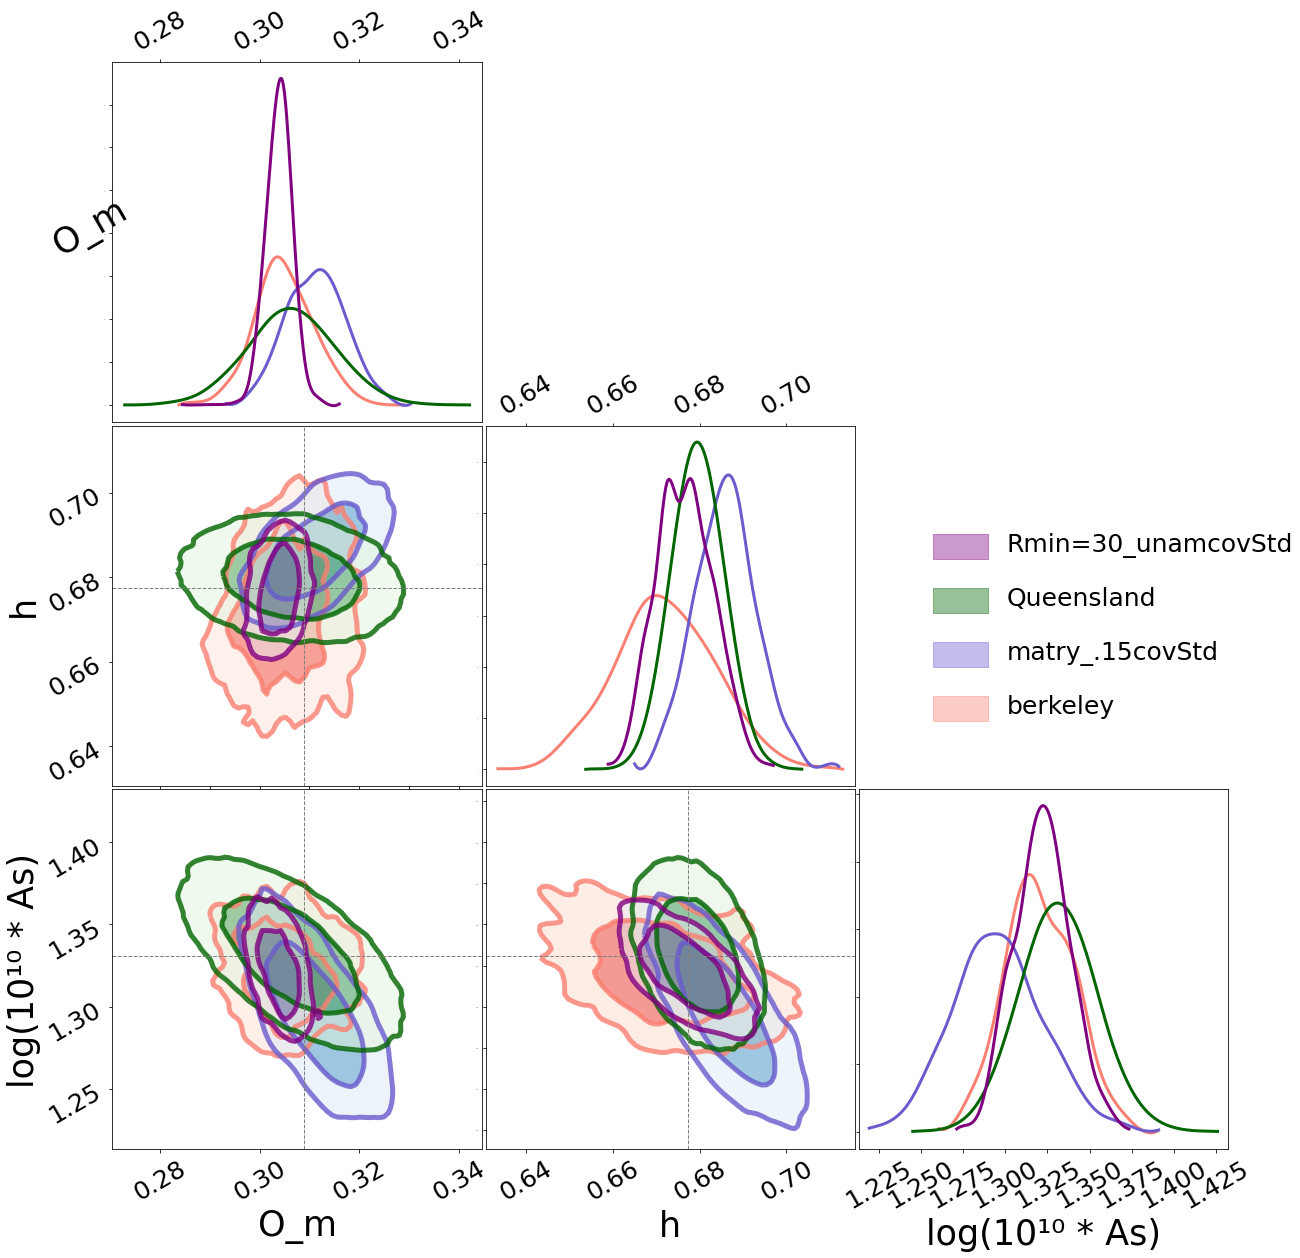

In [9]:
##### Part to do the chains comparison between all the chains from list_chain_names

import matplotlib.gridspec as gridspec
from scipy.stats import kde
from scipy import interpolate



####### SUBSPACE DEFINITION ########

sub_space = [0,1,2]
sub_space1 = [0,1,2]  ##### To select the parameters you want to plot and their order
#sub_space1 = [4,5]

####### Definition of the dictionary that will contain the Mean, Median , sigma_sym, sigma_asym- and sigma_asym+

dict_base = {'chain_name':'', 'params':par_names, 'mean':[],
            'median':[], 'sigma':[], 'sigma+':[], 'sigma-':[]}

s8=0.5589
s8R = 0.53
#fact_mult_par = [1., 1., 1., s8R, 1., 1.]
#fact_mult_parM = [1., 1., 1., s8, 1., 1.]
#fact_add_par = [-1., -s8, -2.1*s8, 1]

fact_mult_par1=[1., 1., 1, 1., 1.,1.,1.]
fact_add_par1 = [0., 0., 0., 0., 0., 0.,0.]
#fact_mult_par2=[1., 1., 1., 1., 1.,1.,1.]
#fact_add_par2 = [0., 0., 0., 0., 0., 0.,0.]

#expected_val = [1, 0., 0.76, 1.3, 0.]
expected_val = [0.3089, 0.6774, np.log10(10**10*2.142e-9), 20 ,0.4,-0.1]

                       
num_par = len(sub_space1)
#print par_names2





##### PLOT OPTIONS #####

opt_points = False    ##### Allows to plot the points from the data on the 2D plots
opt_exp_val = True   ##### Allows to draw the line for the expected value on the 2D plots
opt_mean_hist = False  ##### If True do an histogram, if False do a spline for 1D plots
opt_fill_2D = True    ##### If Ture use plt.contourf, else use plt.contour for the 2D plots
opt_spline = True   ##### If True use the spline rather than 1D histogram



font_labels = 35
font_thicks = 25

levels = np.array([ 0.9545, 0.6827, 0.])    #### To have the 1 and 2 sigma. If we want 3 sigma we have to add 0.995 at the begining
#levels = np.array([ 0.9, 0.7, 0.5, 0.3, 0.1, 0.])
#levels = np.array([ 0.9, 0.65, 0.40, 0.15, 0.])# In order to compare with ZEUS plots

nbins = 80     ##### number of size for the 2D cases heating map to interpolate
nbins_1D = 15  ##### number of bins for histogram to interpolate in 1D case
size_per_fig = 6


min_max_mano = False  ##### if True will use the following min and max. False will use the min and max of the data
#minx=[1.25, 0.2, 0.98, 0.99]
#maxx=[1.5, 1., 1.02, 1.01]

minx=[0.303, 0.672, -8.70 ,0, 0.32, -1.9]
maxx=[0.315, 0.690, -8.650, 50, 0.45,1.9]



##### Define the figure specification with the Grid
plt.figure( figsize=(num_par*size_per_fig+2,num_par*size_per_fig+2) )
gs1 = gridspec.GridSpec(num_par, num_par, width_ratios=(np.zeros(num_par)+6) )
gs1.update(wspace=0.01, hspace=0.01) # set the spacing between axes.


burn_in = 0
data_type = 'total'


for ii in range(num_par):
    #ii = sub_space[ii2]
    for jj in range(ii+1):
        print("We are doing the plot (ii, jj)=", ii, jj)
        ax = plt.subplot(gs1[ii*num_par+jj])
        plt.yticks(fontsize=0)
        plt.xticks(fontsize=0)
        ###################
        ##### case 1D #####
        ###################
        if jj == ii : 
            #list_x_arr = []
            #list_y_arr = []
            list_min = []
            list_max = []
            list_spl = []
            list_spl_x = []
            list_data = []
            
            

            
            for nn in range(len(list_chain_names)):
            
                chain_tot1 = list_chain[nn]
                data = chain_tot1[sub_space1[ii]]*fact_mult_par1[sub_space1[ii]] +fact_add_par1[sub_space1[ii]]
                list_data.append(data)
                #########-----------------------------------
                histo = np.histogram(data, density=True, bins=nbins_1D)
                x_arr = histo[1]
                x_arr = 0.5* (x_arr[1 : len(x_arr)] + x_arr[0 : len(x_arr)-1])
                y_arr = histo[0]
                bin_size = x_arr[1] - x_arr[0]
                
                
                #########-----------------------------------
                
                ##### Part to evaluate the stats values
                


                list_min.append(np.min(data))
                list_max.append(np.max(data))
                



                #### part to interpolate with a spline
                spl = interpolate.CubicSpline(x_arr, y_arr, extrapolate=True)
                inter_array = np.linspace(x_arr.min(), x_arr.max(), nbins_1D*10)
                list_spl.append(spl)
                list_spl_x.append(inter_array)
                
                
            if min_max_mano == True :
                mindata = minx[sub_space1[ii]]
                maxdata = maxx[sub_space1[ii]]
            else :
                mindata = np.min( list_min )
                maxdata = np.max( list_max )
                    
            for nn in range(len(list_chain_names)): 

                #plt.hist(list_data[nn], density=True, range=[ mindata,maxdata],bins=nbins_1D, facecolor=tab_col[nn], alpha=0.3)
                #plt.hist(list_data[nn], density=True, range=[mindata,maxdata],bins=nbins_1D, color=tab_col[nn], alpha=1, histtype='step', lw=2)
                if opt_spline == False:
                    plt.hist(list_data[nn], density=True ,bins=nbins_1D, facecolor=tab_col[nn], alpha=1)
                    plt.hist(list_data[nn], density=True,bins=nbins_1D, color=tab_col[nn], alpha=1, histtype='step', lw=2)
                else:
                    plt.plot(list_spl_x[nn], list_spl[nn](list_spl_x[nn]), color=tab_col[nn], alpha=2, lw=3)


                    if opt_mean_hist == True:
                        plt.axvline(np.mean(list_data[nn]), color=tab_col[nn], lw=4, ls='--')

                #### Part to add labels and thicks when on the border cases

            plt.xlim(mindata, maxdata)
            if ii == num_par-1 : 
                plt.xticks(fontsize=font_thicks, rotation=30)
                plt.xlabel(par_names[sub_space1[jj]], fontsize=font_labels)
            else : 
                ax.xaxis.set_ticks_position('top')
                plt.locator_params(axis='x', nbins=6)
                plt.xticks(fontsize=font_thicks, rotation=30)
            if jj == 0  : 
                plt.yticks(fontsize=0)
                plt.ylabel(par_names[sub_space1[ii]], fontsize=font_labels, rotation=30)
                
                
        ###################
        ##### case 2D #####
        ###################
        else : 
            
            #### Lists definition
            list_data_x = []
            list_data_y = []
            list_zi = []
            list_min_x = []
            list_max_x = []
            list_min_y = []
            list_max_y = []
            list_val_lev = []  ### to keep the cut values for the 2D contours of each chain
            
            for nn in range(len(list_chain_names)):
            
                chain_tot1 = list_chain[nn]
                data_x = chain_tot1[sub_space1[jj]]*fact_mult_par1[sub_space1[jj]] +fact_add_par1[sub_space1[jj]]
                data_y = chain_tot1[sub_space1[ii]]*fact_mult_par1[sub_space1[ii]] +fact_add_par1[sub_space1[ii]]
                list_data_x.append(data_x)
                list_data_y.append(data_y)

                list_min_x.append(np.min(data_x))
                list_max_x.append(np.max(data_x))
                list_min_y.append(np.min(data_y))
                list_max_y.append(np.max(data_y))
            
            
            
            if min_max_mano == True :
                min_glob_x = minx[sub_space1[jj]]
                max_glob_x = maxx[sub_space1[jj]]
                min_glob_y = minx[sub_space1[ii]]
                max_glob_y = maxx[sub_space1[ii]]
            else :
                min_glob_x = np.min(list_min_x )#
                max_glob_x = np.max(list_max_x )#
                min_glob_y = np.min(list_min_y )#
                max_glob_y = np.max(list_max_y )#

            
            #### Definition of 2D grid. Will be the same for all chains
            xi, yi = np.mgrid[min_glob_x:max_glob_x:nbins*1j, min_glob_y:max_glob_y:nbins*1j]
            
            for nn in range(len(list_chain_names)):
            
                
                data = np.zeros( (len(list_data_x[nn]),2) )

                data[:,0] = list_data_x[nn]
                data[:,1] = list_data_y[nn]


                #### Part to use B-spline 2D, non-square, and plot contour levels
                k = kde.gaussian_kde(data.T)
                zi = k(np.vstack([xi.flatten(), yi.flatten()]))

                z_norm = np.zeros(nbins**2)
                z_norm = zi/np.sum(zi)
                z_norm = np.sort(z_norm)
                z_int = np.zeros(nbins**2)
                z_int[0] = z_norm[0]



                delta_xi = (max_glob_x - min_glob_x)/nbins
                delta_yi = (max_glob_y - min_glob_y)/nbins
            
           
            
            
                for kk in range(nbins**2 - 1): 
                    z_int[kk+1] = z_int[kk] + z_norm[kk+1]

                val_lev = np.zeros(len(levels))

                for kk in range(len(levels)) :
                    ind = np.argmin( np.abs(z_int - (1-levels[kk])) )
                    val_lev[kk] = z_norm[ind]

                list_val_lev.append(val_lev)   
                
                ##### Plot 2d contours #####
                if opt_points == True : 
                    plt.plot(data_x, data_y, 'o', color=tab_col[nn], alpha=0.4)

                if opt_fill_2D == True:
                    plt.contourf(xi, yi, zi.reshape(xi.shape)/np.sum(zi), levels = val_lev,  cmap=tab_col_fill[nn], alpha=0.5)
 
                plt.contour(xi, yi, zi.reshape(xi.shape)/np.sum(zi), levels = val_lev, linewidths=[5,5], colors=tab_col[nn], alpha=0.8)

    
    
            if opt_exp_val == True :
                plt.plot( [min_glob_x, max_glob_x], [ expected_val[sub_space[ii]], expected_val[sub_space[ii]]], color='grey', lw=1, ls='--' )
                plt.plot( [ expected_val[sub_space[jj]], expected_val[sub_space[jj]]],[min_glob_y, max_glob_y], color='grey', lw=1, ls='--' )


                #### Part to add labels and thicks when on the border cases
            if ii == num_par-1 : 
                plt.xticks(fontsize=font_thicks, rotation=30)
                plt.locator_params(axis='x', nbins=6)
                plt.xlabel(par_names[sub_space1[jj]], fontsize=font_labels)
            if jj == 0  : 
                plt.yticks(fontsize=font_thicks, rotation=30)
                plt.ylabel(par_names[sub_space1[ii]], fontsize=font_labels)
                plt.locator_params(axis='y', nbins=6)

#### part to draw the legend #####
num_fig=len(sub_space1)
#plt.text(num_fig*size_per_fig -10,num_fig*size_per_fig -10, arr_legend[0], fontsize=25 )
if num_par % 2 == 0 : 
    ax = plt.subplot(gs1[int( num_par/2.*(num_par - 1)) ])
    
else:
    ax = plt.subplot(gs1[np.int( (num_par-1)/2.*num_par +(num_par+1)/2)])
    
plt.xlim( 0,1 )
plt.ylim( 0,1 )
plt.axis('off')
### Loop over the legends
for nn in range(len(list_chain_names)):
    plt.text(0.4,0.2+0.15*nn, arr_legend[nn], fontsize=25 )
    plt.fill_between( [0.2, 0.35],0.2+0.15*nn-0.02 , 0.2+0.15*nn+0.05, color=tab_col[nn], alpha=0.4 )




######
plt.savefig(name_plot, bbox_inches='tight')
plt.show()